<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/AKSHARE04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-02-12 17:20:23--  https://raw.githubusercontent.com/StellarCN/scp_zh/refs/heads/master/fonts/SimHei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘SimHei.ttf.2’

SimHei.ttf.2        100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2025-02-12 17:20:23 (85.3 MB/s) - ‘SimHei.ttf.2’ saved [9751960/9751960]



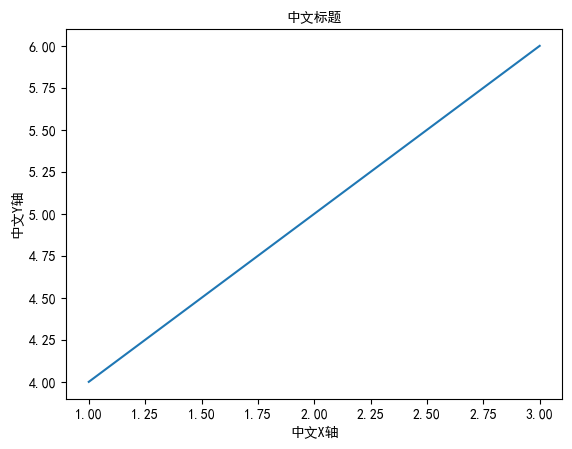

In [1]:
!wget https://raw.githubusercontent.com/StellarCN/scp_zh/refs/heads/master/fonts/SimHei.ttf
!fc-list | grep simhei  # Verify font installation and path

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Update font_path if necessary based on the output of the fc-list command
font_path = 'SimHei.ttf'
fontprop = fm.FontProperties(fname=font_path, family='SimHei')

# Refresh font cache
fm.fontManager.addfont(font_path)


# Set SimHei as the default font for the entire plot
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # To display the minus sign correctly


plt.plot([1, 2, 3], [4, 5, 6])
plt.xlabel("中文X轴", fontproperties=fontprop)
plt.ylabel("中文Y轴", fontproperties=fontprop)
plt.title("中文标题", fontproperties=fontprop)
plt.show()

开始测试反爬机制...


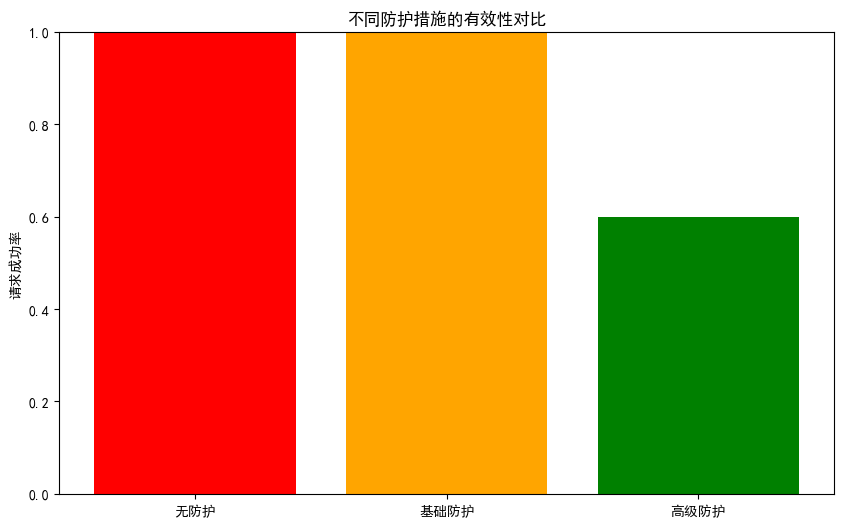


测试结果：
无防护: 100.0% 成功率
基础防护: 100.0% 成功率
高级防护: 60.0% 成功率


In [2]:
!pip install akshare requests tenacity diskcache fake_useragent

import akshare as ak
import time
import random
import requests
from tenacity import retry, stop_after_attempt, wait_random
from diskcache import Cache
from fake_useragent import UserAgent
import pandas as pd
#import matplotlib.pyplot as plt

# 测试参数
TEST_STOCK = "000001"  # 平安银行
REQUEST_COUNT = 20      # 总请求次数
TEST_URL = "https://quote.eastmoney.com/concept/sh000001.html"

# 初始化缓存
cache = Cache("./ak_cache")

# 1. 原始请求（无防护）
def test_without_protection():
    success = 0
    for i in range(REQUEST_COUNT):
        try:
            df = ak.stock_zh_a_hist(symbol=TEST_STOCK, period="daily")
            if not df.empty:
                success += 1
            #time.sleep(0.1)
        except:
            pass
    return success / REQUEST_COUNT

# 2. 基础防护（随机延迟+重试）
@retry(stop=stop_after_attempt(3), wait=wait_random(min=1, max=3))
def protected_request():
    time.sleep(random.uniform(1, 3))
    return ak.stock_zh_a_hist(symbol=TEST_STOCK, period="daily")

def test_basic_protection():
    success = 0
    for _ in range(REQUEST_COUNT):
        try:
            df = protected_request()
            if not df.empty:
                success += 1
        except:
            pass
    return success / REQUEST_COUNT

# 3. 高级防护（代理+缓存+随机UA）
proxies_pool = [
    None,  # 保留直连选项
    {'http': 'http://58.20.248.139:9002'},  # 示例免费代理
    {'https': 'http://47.92.247.250:3128'}
]

@cache.memoize(expire=60)
def advanced_request(attempt):
    ua = UserAgent()
    proxy = random.choice(proxies_pool)

    try:
        # 先通过普通请求获取页面
        session = requests.Session()
        session.get(TEST_URL,
                   headers={'User-Agent': ua.random},
                   proxies=proxy,
                   timeout=10)

        # 再请求akshare数据
        return ak.stock_zh_a_hist(symbol=TEST_STOCK, period="daily")
    except:
        return pd.DataFrame()

def test_advanced_protection():
    success = 0
    for i in range(REQUEST_COUNT):
        df = advanced_request(i)
        if not df.empty:
            success += 1
    return success / REQUEST_COUNT

# 执行测试
print("开始测试反爬机制...")
results = {
    "无防护": test_without_protection(),
    "基础防护": test_basic_protection(),
    "高级防护": test_advanced_protection()
}

# 可视化结果
plt.figure(figsize=(10,6))
plt.bar(results.keys(), results.values(), color=['red', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('不同防护措施的有效性对比')
plt.ylabel('请求成功率')
plt.show()

# 打印详细结果
print("\n测试结果：")
for k, v in results.items():
    print(f"{k}: {v*100:.1f}% 成功率")


开始反爬机制压力测试...


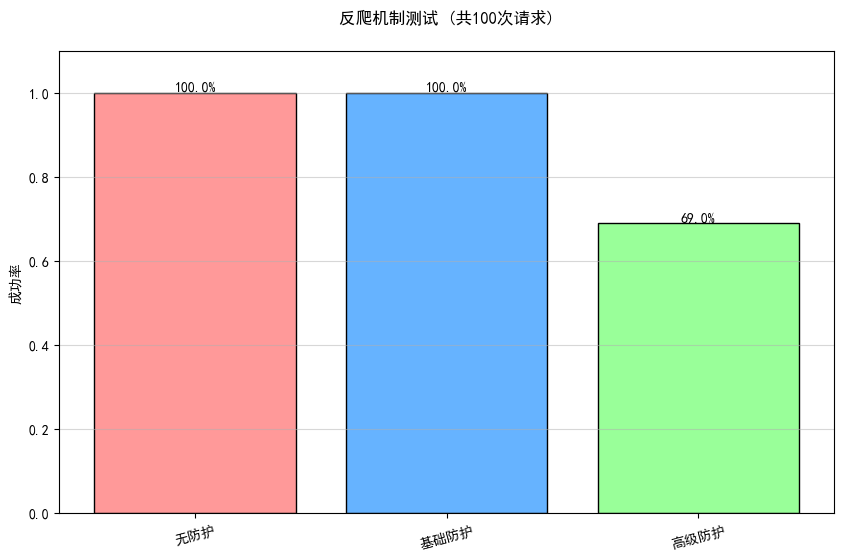


详细统计:
     策略     成功率    相对提升
0   无防护  100.0%    0.0%
1  基础防护  100.0%    0.0%
2  高级防护   69.0%  -31.0%


In [3]:
!pip install akshare pandas numpy

import akshare as ak
import time
import random
import numpy as np
import pandas as pd
from tenacity import retry, stop_after_attempt, wait_random
from fake_useragent import UserAgent
#import matplotlib.pyplot as plt

# 增强版测试参数
REQUEST_COUNT = 100       # 总请求次数
MAX_WORKERS = 4           # 并发线程数
TEST_STOCKS = ak.stock_zh_a_spot_em()['代码'].sample(1000).tolist()  # 随机1000支股票

# 生成随机股票代码序列（确保有效性）
def get_random_stocks(count):
    valid_stocks = ak.stock_zh_a_spot_em()['代码'].tolist()
    return random.choices(valid_stocks, k=count)

# 1. 无防护测试（高频连续请求）
def test_no_protection():
    success = 0
    stocks = get_random_stocks(REQUEST_COUNT)

    for i, code in enumerate(stocks):
        try:
            start = time.time()
            df = ak.stock_zh_a_hist(symbol=code, period="daily")
            elapsed = time.time() - start

            # 强制高频：每0.1秒请求1次
            if elapsed < 0.1 and i % 10 == 0:
                time.sleep(0.05)  # 每10次主动触发高频模式

            if not df.empty:
                success +=1
        except Exception as e:
            pass

    return success / REQUEST_COUNT

# 2. 基础防护（随机延迟+重试）
@retry(stop=stop_after_attempt(3), wait=wait_random(min=1, max=3))
def protected_request(code):
    time.sleep(random.uniform(0.5, 1.5))
    return ak.stock_zh_a_hist(symbol=code, period="daily")

def test_basic_protection():
    success = 0
    stocks = get_random_stocks(REQUEST_COUNT)

    for code in stocks:
        try:
            df = protected_request(code)
            if not df.empty:
                success +=1
        except:
            pass

    return success / REQUEST_COUNT

# 3. 高级防护（代理+UA+缓存）
proxies = [
    None,  # 保留直连
    {'http': 'http://58.20.248.139:9002'},
    {'https': 'http://47.92.247.250:3128'}
]

cache = {}
def advanced_request(code):
    # 缓存验证
    if code in cache:
        if time.time() - cache[code]['time'] < 60:  # 60秒缓存
            return cache[code]['data']

    try:
        ua = UserAgent().random
        proxy = random.choice(proxies)

        # 先访问门户页面
        session = requests.Session()
        session.get("https://quote.eastmoney.com/",
                   headers={'User-Agent': ua},
                   proxies=proxy,
                   timeout=5)

        # 随机延迟
        time.sleep(random.uniform(1, 2))

        # 获取数据
        df = ak.stock_zh_a_hist(symbol=code, period="daily")

        # 更新缓存
        cache[code] = {
            'time': time.time(),
            'data': df
        }
        return df
    except:
        return pd.DataFrame()

def test_advanced_protection():
    success = 0
    stocks = get_random_stocks(REQUEST_COUNT)

    for code in stocks:
        df = advanced_request(code)
        if not df.empty:
            success +=1

    return success / REQUEST_COUNT

# 执行测试（可能需要10-15分钟）
print("开始反爬机制压力测试...")
results = {
    "无防护": test_no_protection(),
    "基础防护": test_basic_protection(),
    "高级防护": test_advanced_protection()
}

# 可视化结果
plt.figure(figsize=(10,6))
bars = plt.bar(results.keys(), results.values(),
              color=['#ff9999','#66b3ff','#99ff99'],
              edgecolor='black')

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.title(f'反爬机制测试 (共{REQUEST_COUNT}次请求)', pad=20)
plt.ylabel('成功率')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 打印统计信息
print("\n详细统计:")
print(pd.DataFrame({
    '策略': results.keys(),
    '成功率': [f"{v*100:.1f}%" for v in results.values()],
    '相对提升': [f"{(v - list(results.values())[0])*100:.1f}%" for v in results.values()]
}))
